

# Removing muscle ICA components

Gross movements produce widespread high-frequency activity across all channels
that is usually not recoverable and so the epoch must be rejected as shown in
`ex-muscle-artifacts`. More ubiquitously than gross movements, muscle
artifact is produced during postural maintenance. This is more appropriately
removed by ICA otherwise there wouldn't be any epochs left! Note that muscle
artifacts of this kind are much more pronounced in EEG than they are in MEG.


In [85]:
# Authors: Alex Rockhill <aprockhill@mailbox.org>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [86]:
import pandas as pd
import mne
import numpy as np

# 1. Ruta del archivo
fname = r"C:\Users\franc\Franco\2025-2\INTRO A SEÑALES BIOMEDICAS\PROYECTO\GRUPO-08-ISB-2025-II\Laboratorios\Laboratorio 10 - EEG\OpenBCI-RAW-2025-09-17_12-45-51.txt"

# 2. Leer el archivo OpenBCI
# - comment='%' → ignora líneas que empiezan con %
# - engine='python' + sep=None → detecta si usa coma, tab o espacios
df = pd.read_csv(
    fname,
    comment='%',
    sep=None,
    engine='python'
)

# 3. A veces OpenBCI pone una fila con texto (Sample Index...). Vamos a forzar a numérico.
#    errors='coerce' convierte lo que no es número en NaN
df = df.apply(pd.to_numeric, errors='coerce')

# 4. Quitar columnas que quedaron totalmente vacías o filas que son solo NaN
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')

# Ahora df debería ser puro número

# 5. Elegimos cuántos canales EEG queremos.
#    Supongamos que tus primeros 8 canales son EEG. Si usaste 4, cambia a range(4).
n_eeg = 8
# Si el archivo tiene menos columnas que eso, ajustamos
n_eeg = min(n_eeg, df.shape[1])

eeg_idx = list(range(n_eeg))
data = df.iloc[:, eeg_idx].to_numpy().T   # (n_channels, n_samples)

# 6. Crear nombres de canal
ch_names = [f"EEG{i+1}" for i in range(n_eeg)]

# 7. Frecuencia de muestreo (ajusta si no es 250 Hz)
sfreq = 250.0

# 8. Crear info y Raw
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(data, info)

# 9. Recortar (si tu señal dura menos de 30 s, baja este valor)
raw.crop(tmin=0, tmax=30)

# 10. Filtrar como en tu código original
raw.load_data()
raw.filter(l_freq=1.0, h_freq=None)

# 11. Mantener EEG
raw.pick(picks="eeg", exclude="bads")

print(raw)

from mne.preprocessing import ICA

# 1. Crear el objeto ICA
#    Usa 8 componentes (tantos como canales EEG que tienes)
n_components = len(raw.info["ch_names"])

ica = ICA(
    n_components=n_components,   # igual que número de canales
    method="picard",             # algoritmo ICA
    max_iter="auto",             # parar automáticamente cuando converge
    random_state=97              # resultado reproducible
)

# 2. Ajustar ICA a tus datos EEG
print("⚙ Ejecutando ICA, esto puede tardar unos segundos...")
ica.fit(raw)

print("✅ ICA completado. Puedes visualizar los componentes así:")
print("   ica.plot_components()   # muestra mapas espaciales")
print("   ica.plot_sources(raw)   # muestra señales temporales")


ica.plot_sources(raw)

Creating RawArray with float64 data, n_channels=8, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

<RawArray | 8 x 7501 (30.0 s), ~479 KiB, data loaded>
⚙ Ejecutando ICA, esto puede tardar unos segundos...
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
✅ ICA completado. Puedes visualizar los componentes así:
   ica.plot_components()   # muestra mapas espaciales
   ica.plot_sources(raw)   # muestra señales temporales
Creating Ra

Run ICA



In [87]:
ica = mne.preprocessing.ICA(
    n_components=8, method="picard", max_iter="auto", random_state=97
)
ica.fit(raw)


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.


Method,picard
Fit parameters,max_iter=500
Fit,29 iterations on raw data (7501 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


Remove components with postural muscle artifact using ICA



In [88]:
ica.plot_sources(raw)

Creating RawArray with float64 data, n_channels=8, n_times=7501
    Range : 0 ... 7500 =      0.000 ...    30.000 secs
Ready.


By inspection, let's select out the muscle-artifact components based on
:footcite:`DharmapraniEtAl2016` manually.

The criteria are:

- Positive slope of log-log power spectrum between 7 and 75 Hz
  (here just flat because it's not in log-log)
- Peripheral focus or dipole/multi-pole foci (the blue and red
  blobs in the topomap are far from the vertex where the most
  muscle is)
- Single focal point (low spatial smoothness; there is just one focus
  of the topomap compared to components like the first ones that are
  more likely neural which spread across the topomap)

The other attribute worth noting is that the time course in
:func:`mne.preprocessing.ICA.plot_sources` looks like EMG; you can
see spikes when each motor unit fires so that the time course looks fuzzy
and sometimes has large spikes that are often at regular intervals.

ICA component 13 is a textbook example of what muscle artifact looks like.
The focus of the topomap for this component is right on the temporalis
muscle near the ears. There is also a minimum in the power spectrum at around
10 Hz, then a maximum at around 25 Hz, generally resulting in a positive
slope in log-log units; this is a very typical pattern for muscle artifact.



Posiciones de los electrodos:
Fp1: [-0.02060569  0.05874197 -0.006291  ]
Fpz: [ 0.0001123  0.088247  -0.001713 ]
Fp2: [ 0.02091061  0.05942713 -0.006372  ]
AF9: [-0.0489708  0.0640872 -0.047683 ]
AF7: [-0.0548397  0.0685722 -0.01059  ]
AF5: [-0.0454307  0.0728622  0.005978 ]
AF3: [-0.0337007  0.0768371  0.021227 ]
AF1: [-0.0184717  0.0799041  0.032752 ]
AFz: [0.0002313 0.080771  0.035417 ]
AF2: [0.0198203 0.0803019 0.032764 ]
AF4: [0.0357123 0.0777259 0.021956 ]
AF6: [0.0465843 0.0738078 0.006034 ]
AF8: [ 0.0557433  0.0696568 -0.010755 ]
AF10: [ 0.0504352  0.0638698 -0.048005 ]
F9: [-0.0701019  0.0416523 -0.049952 ]
F7: [-0.0702629  0.0424743 -0.01142  ]
F5: [-0.0644658  0.0480353  0.016921 ]
F3: [-0.0502438  0.0531112  0.042192 ]
F1: [-0.0274958  0.0569311  0.060342 ]
Fz: [0.0003122 0.058512  0.066462 ]
F2: [0.0295142 0.0576019 0.05954  ]
F4: [0.0518362 0.0543048 0.040814 ]
F6: [0.0679142 0.0498297 0.016367 ]
F8: [ 0.0730431  0.0444217 -0.012    ]
F10: [ 0.0721141  0.0420667 -0.050452

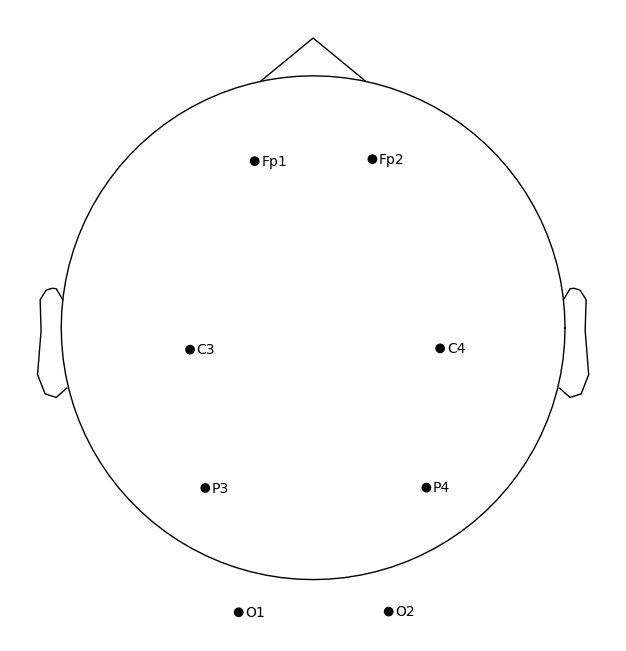

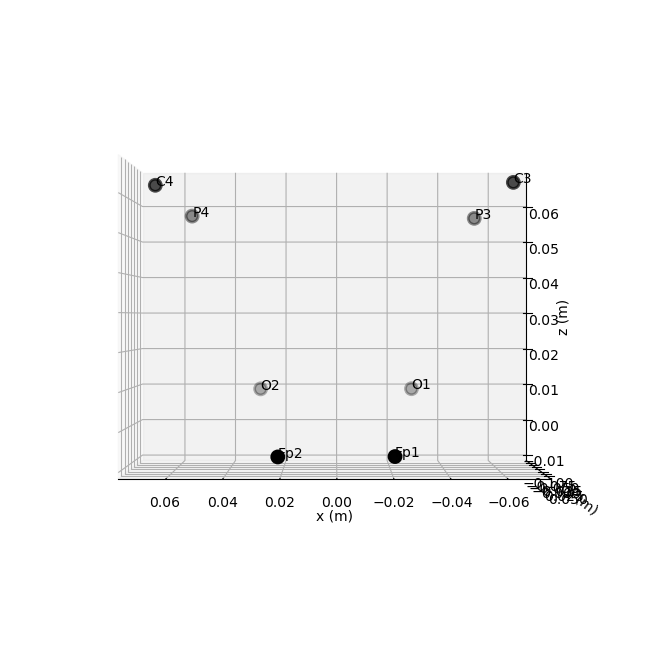

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline co

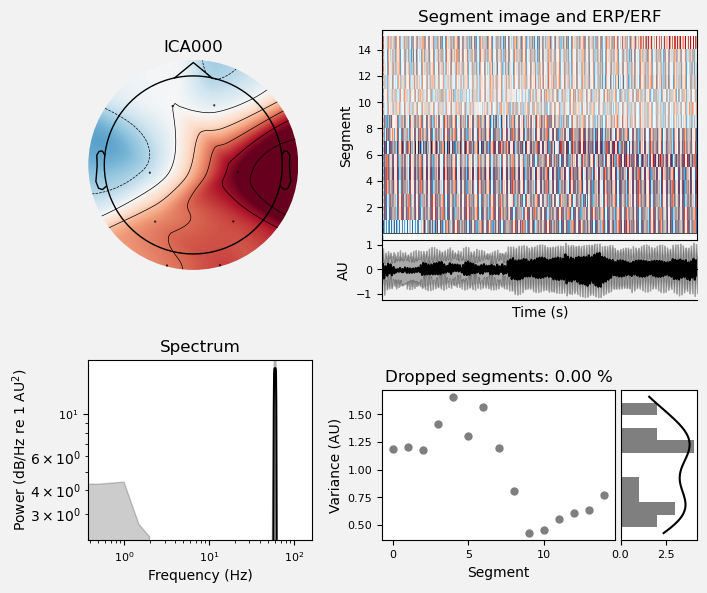

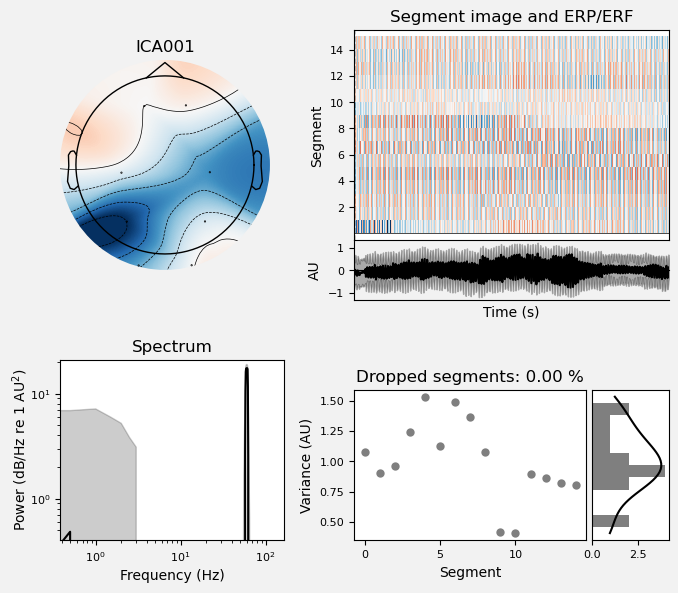

c:\Users\franc\anaconda3\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


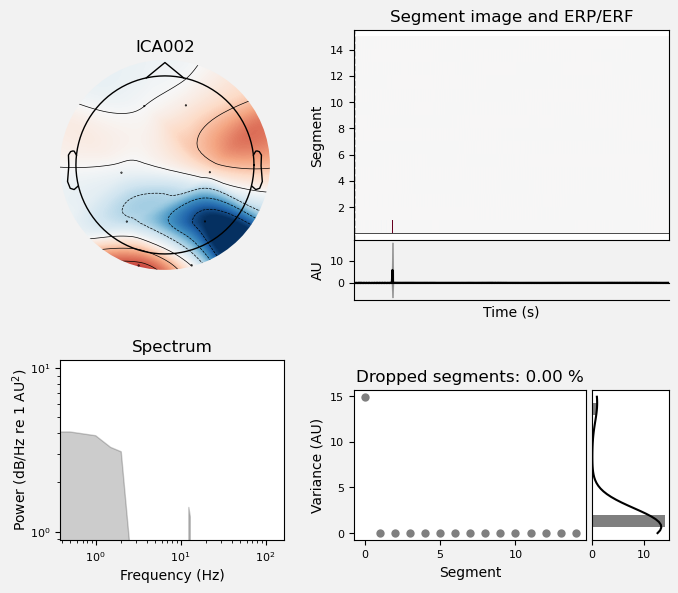

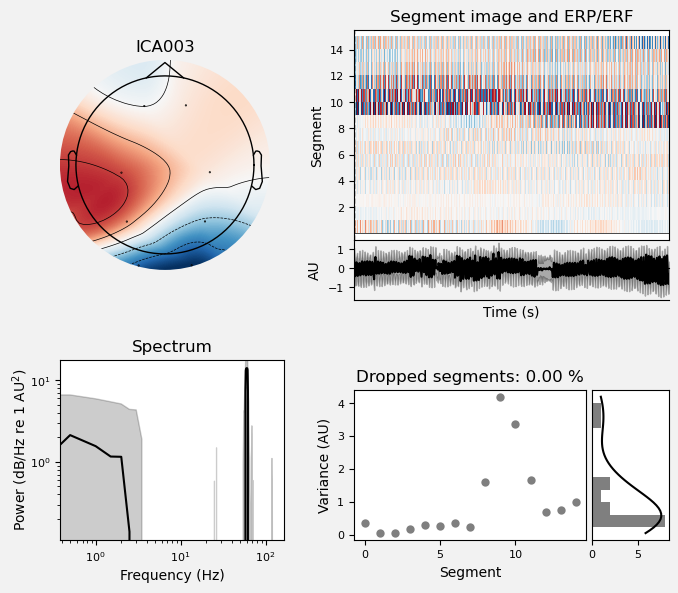

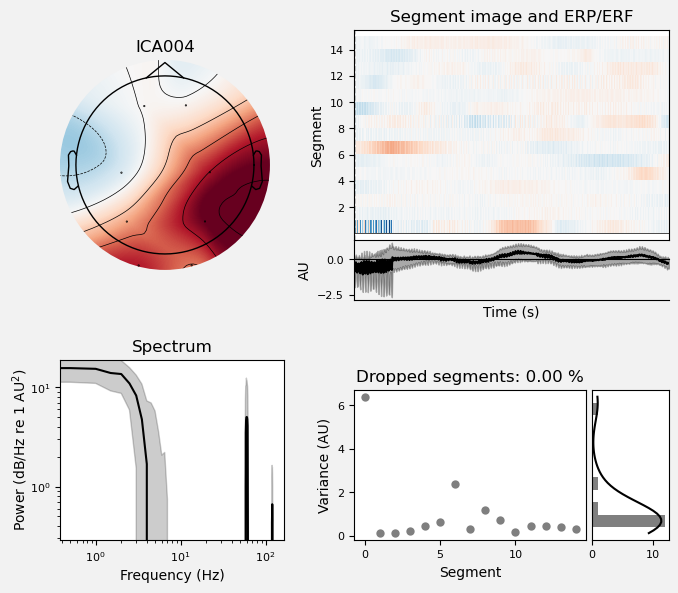

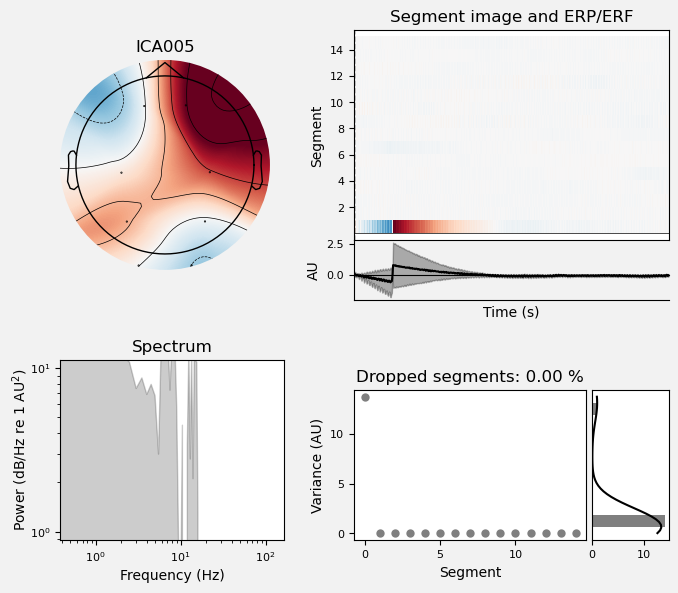

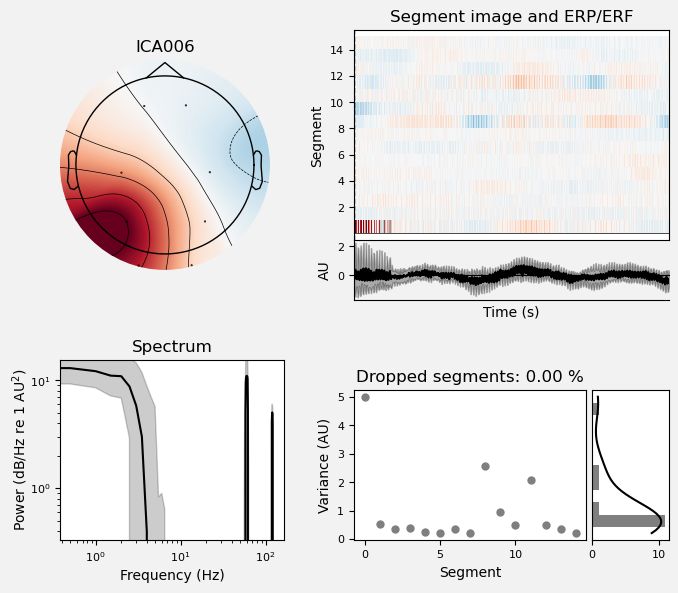

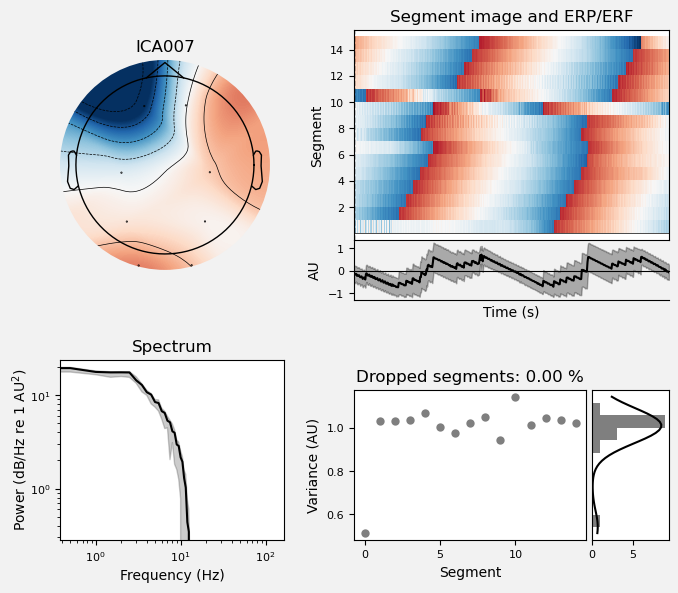

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [89]:
import mne
import numpy as np

# Renombrar canales
raw.rename_channels({
    'EEG1': 'Fp1', 'EEG2': 'Fp2', 'EEG3': 'C3', 'EEG4': 'C4',
    'EEG5': 'P3', 'EEG6': 'P4', 'EEG7': 'O1', 'EEG8': 'O2'
})

# Obtener montaje estándar
montage = mne.channels.make_standard_montage("standard_1020")

# Copiar posiciones y corregir SOLO Fp1 y Fp2
pos = montage.get_positions()['ch_pos'].copy()

# Ajustar SOLO Fp1 y Fp2 para que estén dentro de la cabeza
# Dejar todos los demás electrodos en sus posiciones originales
pos['Fp1'] = np.array([pos['Fp1'][0] * 0.7, pos['Fp1'][1] * 0.7, pos['Fp1'][2] * 0.9])
pos['Fp2'] = np.array([pos['Fp2'][0] * 0.7, pos['Fp2'][1] * 0.7, pos['Fp2'][2] * 0.9])

# Los demás electrodos (C3, C4, P3, P4, O1, O2) se mantienen en sus posiciones originales
# No necesitan ajuste

# Crear montaje personalizado
montage_custom = mne.channels.make_dig_montage(ch_pos=pos, coord_frame='head')
raw.set_montage(montage_custom)

# Verificar posiciones
print("Posiciones de los electrodos:")
for ch, coords in pos.items():
    print(f"{ch}: {coords}")

# Graficar en 2D
raw.plot_sensors(show_names=True, title="Vista 2D - Solo Fp1 y Fp2 ajustados")

# Graficar en 3D para verificar la posición
raw.plot_sensors(show_names=True, kind='3d', title="Vista 3D - Solo Fp1 y Fp2 ajustados")

# Ajustar ICA
ica = mne.preprocessing.ICA(
    n_components=8, method="picard", max_iter="auto", random_state=97
)
ica.fit(raw)

# Graficar propiedades ICA
idx = list(range(ica.n_components_))
ica.plot_properties(raw, picks=idx, log_scale=True)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated


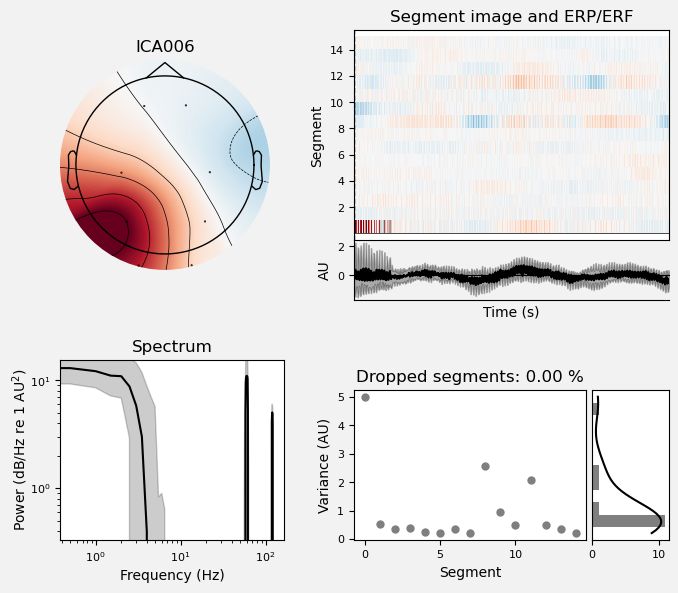

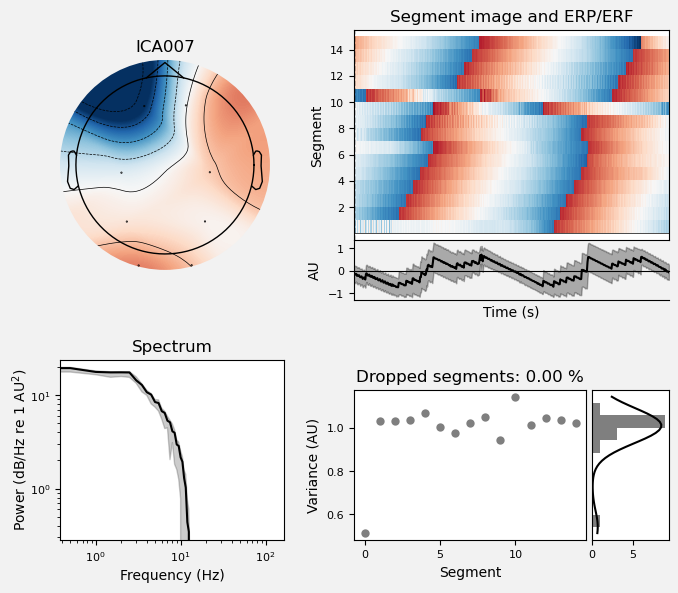

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


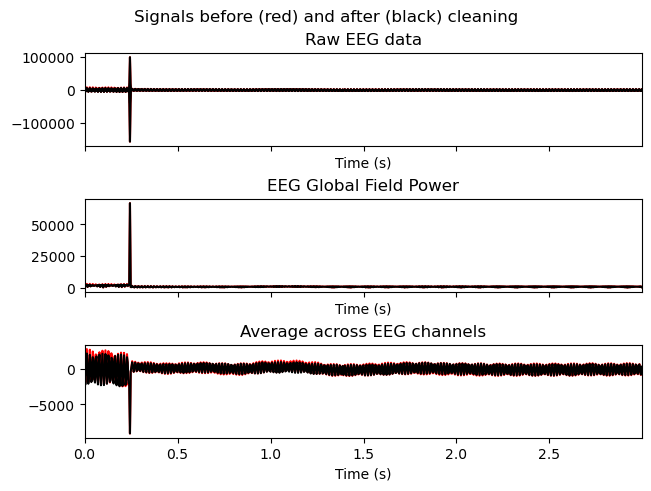

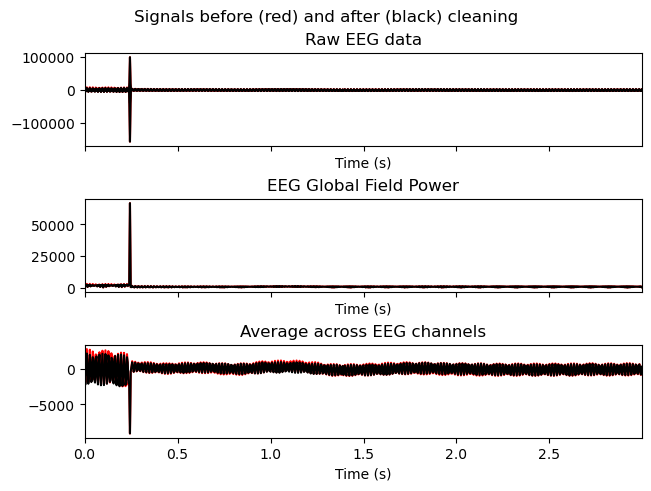

In [90]:
muscle_idx = [i for i in range(ica.n_components_) if i >= 6]  # Esto será [6, 7] si n_components=8
ica.plot_properties(raw, picks=muscle_idx, log_scale=True)

# first, remove blinks and heartbeat to compare
blink_idx = [0]  # ejemplo: componente 0 = parpadeo
heartbeat_idx = [5]  # ejemplo: componente 5 = latido
ica.apply(raw, exclude=blink_idx + heartbeat_idx)
ica.plot_overlay(raw, exclude=muscle_idx)

Finally, let's try an automated algorithm to find muscle components
and ensure that it gets the same components we did manually.



Effective window size : 8.192 (s)


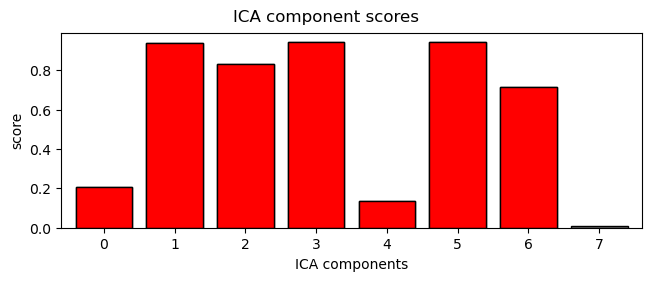

Manually found muscle artifact ICA components:      [6, 7]
Automatically found muscle artifact ICA components: [0, 1, 2, 3, 4, 5, 6]


In [91]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(
    f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
    f"Automatically found muscle artifact ICA components: {muscle_idx_auto}"
)

## Let's now replicate this on the EEGBCI dataset



In [92]:
for sub in (1, 2):
    raw = mne.io.read_raw_edf(
        mne.datasets.eegbci.load_data(subject=sub, runs=(1,))[0], preload=True
    )
    mne.datasets.eegbci.standardize(raw)  # set channel names
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    raw.filter(l_freq=1.0, h_freq=None)

    # Run ICA
    ica = mne.preprocessing.ICA(
        n_components=15, method="picard", max_iter="auto", random_state=97
    )
    ica.fit(raw)
    ica.plot_sources(raw)
    muscle_idx_auto, scores = ica.find_bads_muscle(raw)
    ica.plot_properties(raw, picks=muscle_idx_auto, log_scale=True)
    ica.plot_scores(scores, exclude=muscle_idx_auto)

    print(
        f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
        "Automatically found muscle artifact ICA components: "
        f"{muscle_idx_auto}"
    )

TypeError: load_data() got an unexpected keyword argument 'subject'. Did you mean 'subjects'?

## References

Dhani Dharmaprani, Hoang K. Nguyen, Trent W. Lewis, Dylan DeLosAngeles, John O. Willoughby, and Kenneth J. Pope. A comparison of independent component analysis algorithms and measures to discriminate between EEG and artifact components. In 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), 825–828. Orlando, FL, USA, 2016. IEEE. doi:10.1109/EMBC.2016.7590828.

